In [10]:
import pandas as pd

# File paths
fpkm_file = "GSE183947_fpkm.csv"
metadata_file = "GSE183947_series_matrix.txt"

# Step 1: Load FPKM data
print("Loading FPKM data...")
fpkm_data = pd.read_csv(fpkm_file)
fpkm_data = fpkm_data.rename(columns=lambda x: x.strip())  # Clean column names
print(f"FPKM data loaded. Shape: {fpkm_data.shape}")

# Step 2: Extract Metadata
print("Extracting metadata...")
metadata_dict = {}
with open(metadata_file, "r") as f:
    for line in f:
        if line.startswith("!Sample_title") or line.startswith("!Sample_characteristics_ch1"):
            key, *values = line.strip().split("\t")
            metadata_dict[key] = values

# Convert metadata into a DataFrame
metadata = pd.DataFrame(metadata_dict).T
metadata.columns = metadata.iloc[0]  # Set first row as header
metadata = metadata[1:]  # Remove the header row
metadata.reset_index(inplace=True, drop=True)  # Reset index
metadata = metadata.rename(columns=lambda x: x.strip())  # Clean column names
metadata.columns.name = None  # Remove the column name from index

# Clean and adjust metadata sample titles
metadata.columns = [col.replace('"', '').strip() for col in metadata.columns]
print(f"Metadata extracted. Shape: {metadata.shape}")

# Step 3: Create a mapping between metadata and FPKM columns
# Assuming FPKM columns correspond to metadata samples in order
fpkm_samples = fpkm_data.columns[1:]  # Exclude 'GeneID'
metadata_samples = metadata.columns  # Metadata sample titles
mapping = dict(zip(metadata_samples, fpkm_samples))  # Create a mapping

# Step 4: Merge Data
print("Merging metadata with FPKM data...")
fpkm_data_t = fpkm_data.set_index("Unnamed: 0").T.reset_index()  # Transpose FPKM data
fpkm_data_t.rename(columns={"index": "Sample_title"}, inplace=True)

# Map FPKM sample names to metadata sample names
fpkm_data_t["Sample_title"] = fpkm_data_t["Sample_title"].map({v: k for k, v in mapping.items()})

# Merge metadata and FPKM data
merged_data = pd.merge(metadata.T, fpkm_data_t, left_index=True, right_on="Sample_title")

# Step 5: Save the merged data
output_file = "merged_GSE183947.csv"
merged_data.to_csv(output_file, index=False)
print(f"Merged data saved to {output_file}. Shape: {merged_data.shape}")
merged_data.head()


Loading FPKM data...
FPKM data loaded. Shape: (20246, 61)
Extracting metadata...
Metadata extracted. Shape: (1, 60)
Merging metadata with FPKM data...
Merged data saved to merged_GSE183947.csv. Shape: (60, 20248)


,0,Sample_title,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,CTB-96E2.2,CTC-432M15.3,RP11-986E7.7,RP11-761B3.1,ZBTB8B,RP11-1084J3.4,RP11-944L7.5,FLJ00388,RP11-474G23.1,AC005358.1
0,"""donor: 102548""",tumor rep1,0.93,0.0,0.00,5.78,2.83,4.80,1.37,21.92,...,0.0,0.0,0.00,0.00,38.27,0.00,0.0,0.00,0.00,0.0
1,"""donor: 104338""",tumor rep2,1.97,0.0,0.43,5.17,6.26,1.83,1.78,10.48,...,0.0,0.0,0.10,0.03,30.99,0.16,0.0,0.00,0.00,0.0
2,"""donor: 105094""",tumor rep3,0.00,0.0,0.00,8.76,3.37,0.00,0.00,0.00,...,0.0,0.0,0.00,0.00,47.57,0.00,0.0,0.00,0.00,0.0
3,"""donor: 109745""",tumor rep4,5.45,0.0,3.43,4.58,6.24,4.23,2.59,23.78,...,0.0,0.0,1.15,0.00,12.27,0.00,0.0,0.83,0.10,0.0
4,"""donor: 1906415""",tumor rep5,4.52,0.0,8.45,7.20,5.16,15.87,9.21,14.95,...,0.0,0.0,0.00,0.00,4.69,0.00,0.0,0.00,0.64,0.0


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Differential Expression Analysis
# Assuming 'merged_data' has a column 'Sample_type' indicating 'Tumor' or 'Normal'
tumor_samples = merged_data[merged_data['Sample_title'].str.contains('tumor', case=False)]
normal_samples = merged_data[merged_data['Sample_title'].str.contains('normal', case=False)]

print(f"Tumor samples: {tumor_samples.shape[0]}")
print(f"Normal samples: {normal_samples.shape[0]}")

# Perform t-test for each gene
p_values = []
for gene in merged_data.columns[2:]:
    tumor_values = tumor_samples[gene].astype(float)
    normal_values = normal_samples[gene].astype(float)
    t_stat, p_val, _ = sm.stats.ttest_ind(tumor_values, normal_values)
    p_values.append(p_val)

print(p_values[:5])
# Adjust p-values for multiple testing using Benjamini-Hochberg method
# Filter out NaNs and infinite values from p-values
p_values = np.array(p_values)
finite_mask = np.isfinite(p_values)
p_values = p_values[finite_mask]

# Adjust p-values for multiple testing using Benjamini-Hochberg method
_, p_adj, _, _ = sm.stats.multipletests(p_values, method='fdr_bh')

# Biomarker Discovery
# Select genes with adjusted p-value < 0.01
genes_tested = merged_data.columns[2:][finite_mask]  # Ensure the number of genes matches the number of p-values
significant_genes = genes_tested[p_adj < 0.01]
print(f"Significant genes percentage: {significant_genes.shape[0]/len(p_values)*100:.2f}%")

# Clustering and Classification
# Prepare data for classification
X = merged_data[significant_genes].astype(float)
y = merged_data['Sample_title'].apply(lambda x: 1 if 'tumor' in x.lower() else 0)  # Encode Tumor as 1, Normal as 0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Tumor samples: 30
Normal samples: 30


C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\sta

[0.02484786373250977, 0.032285773164151516, 0.1499098584038692, 0.0010742365831044737, 0.21721264537870344]
Significant genes percentage: 13.64%
Training set shape: (42, 2742)
Testing set shape: (18, 2742)


C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\stats\weightstats.py:652: RuntimeWarning: invalid value encountered in scalar divide
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\sta

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



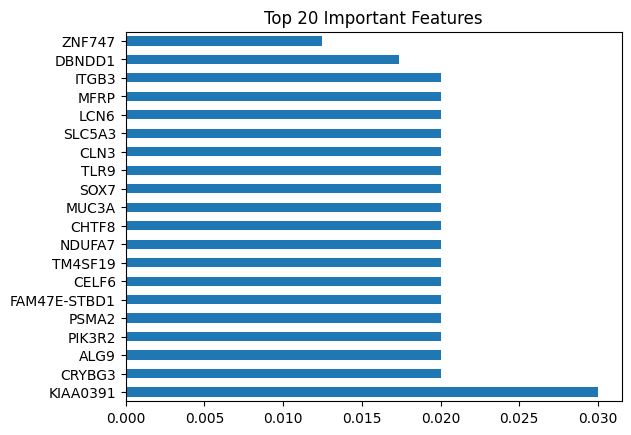

In [18]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importances
feature_importances = pd.Series(clf.feature_importances_, index=significant_genes)
feature_importances.nlargest(20).plot(kind='barh')
plt.title("Top 20 Important Features")
plt.show()

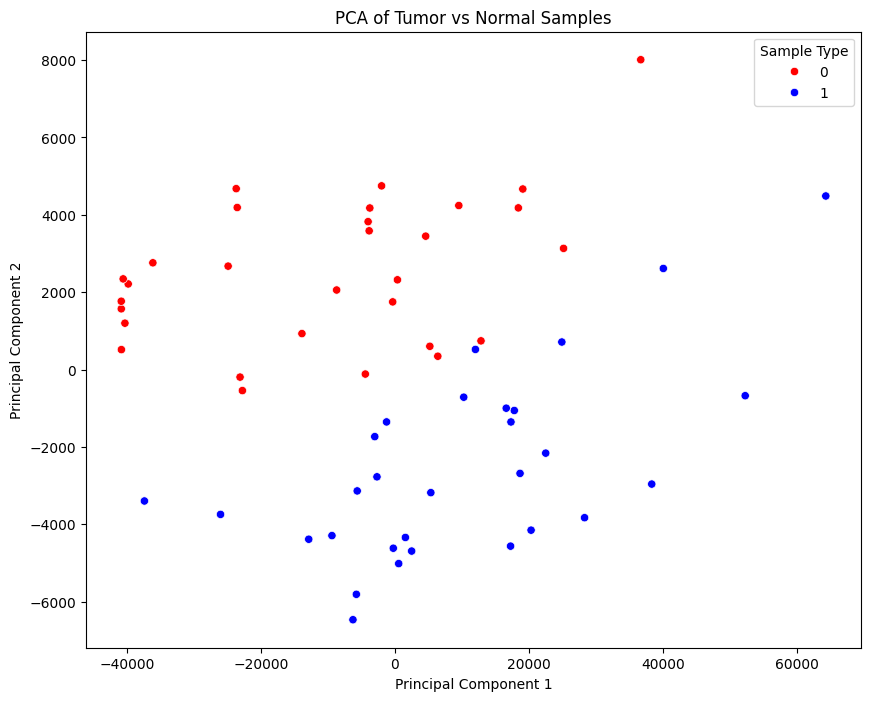

In [11]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_pca = pca.fit_transform(X)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Sample_type'] = y.values

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Sample_type', data=pca_df, palette=['red', 'blue'])
plt.title('PCA of Tumor vs Normal Samples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sample Type')
plt.show()

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         8

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



C:\Users\giord\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


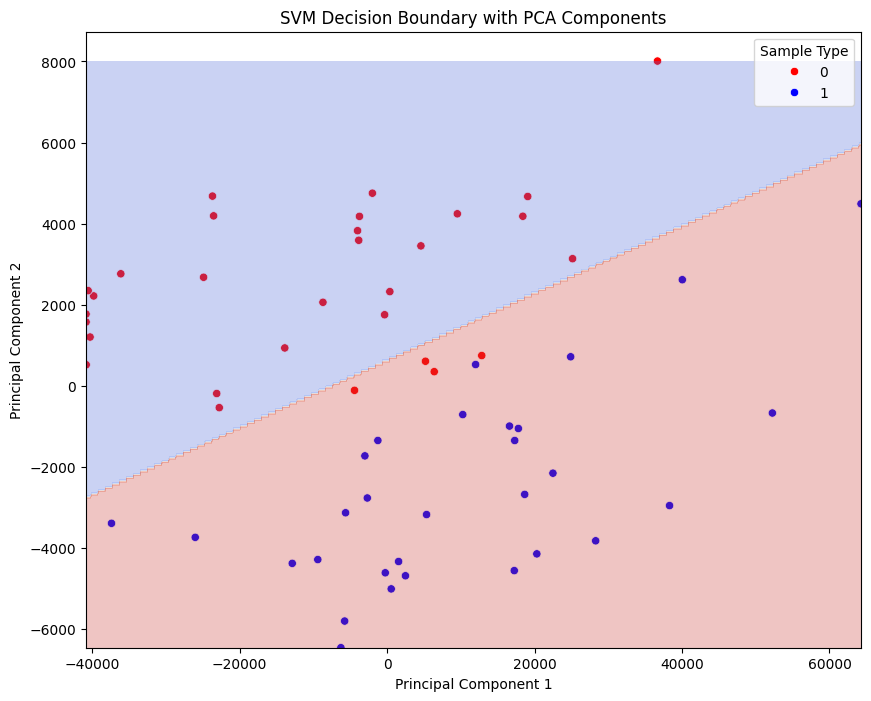

In [19]:
from sklearn.svm import SVC
# Train a Support Vector Machine (SVM) classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train, y_train)

# Predict and evaluate the SVM model
y_pred_svm = svm_clf.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot SVM decision boundary using PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Sample_type', data=pca_df, palette=['red', 'blue'])

# Create a mesh to plot the decision boundary
h = 80  # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision boundary
Z = svm_clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

plt.title('SVM Decision Boundary with PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Sample Type')
plt.show()